## Predicting Adult Census Income Using XGBoost Gradient Boosted Trees System

### Haibin Lai 12211612

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.

The gradient boosted trees has been around for a while, and there are a lot of materials on the topic. Boosted trees in a self-contained and principled way use the elements of supervised learning. We think this explanation is cleaner, more formal, and motivates the model formulation used in XGBoost.

### Running Preparation
**Needed Python Version:**
 > \>=3.09 
 My computer runs well in 3.11

**Needed Package:**

| Library    | Version | Notes                    |
|------------|---------|--------------------------|
| pandas     | 2.2.1   | Recommended              |
| seaborn    | 0.12.2  | Recommended              |
| sklearn    | 1.4.0   | Recommended (1.5.0 tested OK) |
| xgboost    | 2.0.3   | Recommended              |

### Using xgboost:
XGBoost: eXtreme Gradient Boosting library.
Contributors: https://github.com/dmlc/xgboost/blob/master/CONTRIBUTORS.md 

**Installing**

Pip 21.3+ is required

```commandline
pip install xgboost
```

![XGBoost](Img/XGBoost.png "AWS")


In [989]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

## Data Preprocessing:
### 1. Preprocessing of loading and data reformatting
XGBoost will automatically train the input data as a whole csv just like excel. To meet its requirement, we need to add trainlabel.csv's col into traindata.csv

In [990]:
# 读取 traindata.csv 文件
train_df = pd.read_csv("data/traindata.csv")

# 读取trainlabel.txt文件
with open('data/trainlabel.txt', 'r') as file:
    lines = file.readlines()

# 解析文本数据并创建DataFrame
data = {'Label': [line.strip() for line in lines]}
df = pd.DataFrame(data)

# 将DataFrame保存为CSV文件
df.to_csv('data/trainlabel.csv', index=False)

print("trainlabel.txt 已成功转换为 trainlabel.csv")

trainlabel.txt 已成功转换为 trainlabel.csv


In [991]:
# 读取 trainlabel.csv 文件，假设数据列名为 'income'
data_df = pd.read_csv("data/trainlabel.csv")

# 将 'income' 数据列添加到 train_df 中
train_df['Income'] = data_df

# 将修改后的 train_df 保存为新的 CSV 文件
train_df.to_csv("data/traindata_preprocessed.csv", index=False)

In [992]:
df = pd.read_csv('data/traindata_preprocessed.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Income
0,77,Local-gov,177550,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,3818,0,14,United-States,0
1,40,Self-emp-inc,475322,Bachelors,13,Separated,Craft-repair,Own-child,White,Male,0,0,50,United-States,0
2,29,Self-emp-not-inc,341672,HS-grad,9,Married-spouse-absent,Transport-moving,Other-relative,Asian-Pac-Islander,Male,0,1564,50,India,1
3,41,Private,184378,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,0
4,22,Private,306967,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,0


### 2. Preprocessing of duplicating the same row

def duplicated(self,subset: Hashable | Sequence\[Hashable] | None = None, keep: Literal\["first", "last", False] = "first")
  
-> Series
        Return boolean Series denoting duplicate rows.
        Considering certain columns is optional.
See Also
* Index.duplicated: Equivalent method on index.
* Series.duplicated: Equivalent method on Series.
* Series.drop_duplicates: Remove duplicate values from Series.
* DataFrame.drop_duplicates: Remove duplicate values from DataFrame.

In [993]:
df.loc[df.duplicated() == True]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Income
5721,44,Private,367749,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,Mexico,0
9853,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,0
15108,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,0
16958,42,Private,204235,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
18372,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,0
18382,23,Private,240137,5th-6th,3,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,55,Mexico,0
19488,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
19733,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
20026,27,Private,255582,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0
20405,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,0


### 3. Preprocessing of transforming data and its recognition:

1. **Initialization**: 


   label_encoder = LabelEncoder()
   - Initializes a `LabelEncoder` object, which is a utility class for converting categorical labels into numerical values. It assigns a unique integer to each category in the data.

2. **Defining Categorical Columns**: 


   categorical_columns = ['Income', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
   - Defines a list of column names in the DataFrame `df` that contain categorical data.

3. **Encoding Categorical Data**: 


   df[categoricalcolumns] = df[categoricalcolumns].apply(labelencoder.fittransform)
   - Applies the `fit_transform` method of the `LabelEncoder` object to each column specified in `categorical_columns`.
   - Fits the encoder to the unique categories in each column (`fit`), and then transforms the categorical labels into numerical values (`transform`).
   - Assigns these transformed values back to the respective columns in the DataFrame `df`.

Essentially, this code converts the categorical variables in the specified columns of the DataFrame into numerical representations, which can be used as input for machine learning models of XGBoost. This preprocessing step is necessary because many machine learning algorithms require numerical input data.

This Markdown format provides a structured explanation of the code snippet, making it easier to understand each step and its purpose.

In [994]:
label_encoder = LabelEncoder()
categorical_columns = ['age','workclass','fnlwgt', 'education','education.num' ,'marital.status', 'occupation', 'relationship', 'race', 'sex','hours.per.week', 'native.country']

# 针对每一列进行标签编码
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
    


### Data Splitting:

xtrain, xtest, ytrain, ytest = traintestsplit(df.drop(columns=['Income']), df['Income'], testsize=0.12, randomstate=38)
- **Splitting Data**: 
  - The `train_test_split` function from `sklearn.model_selection` is used to split the DataFrame `df` into training and testing sets.
  - `df.drop(columns=['Income'])` drops the 'Income' column from the DataFrame `df` to create the feature set (`x_train` and `x_test`).
  - `df['Income']` selects the 'Income' column as the target variable (`y_train` and `y_test`).
  - `test_size=0.12` specifies that 12% of the data will be used for testing, while the remaining 88% will be used for training.
  - `random_state=38` sets the random seed for reproducibility.



In [995]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Income']), df['Income'], test_size=0.13, random_state=39)

### Feature Scaling:


scaler = StandardScaler()
xtrain = scaler.fittransform(xtrain)
xtest = scaler.transform(x_test)
- **Standardization (Feature Scaling)**: 
  - A `StandardScaler` object is initialized, which is used to standardize features by removing the mean and scaling to unit variance.
  - `scaler.fit_transform(x_train)` fits the scaler to the training data (`x_train`) and then transforms it.
  - `scaler.transform(x_test)` applies the same transformation to the testing data (`x_test`) using the parameters learned from the training data.

These steps ensure that the data is appropriately split into training and testing sets, and the features are scaled for better performance of machine learning models.

This Markdown explanation breaks down the code into two parts: data splitting and feature scaling, explaining each step in detail.

In [996]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

 **Instantiating XGBClassifier**
 -----------------
xgb = XGBClassifier()

We create an instance of the XGBoost classifier model called xgb.


**Training the model with training data**
 -----------------
xgb.fit(x_train, y_train)

We train the XGBoost classifier model (xgb) using the training data (x_train and y_train) using the fit method.


**Predicting the labels for test data**
 -----------------
y_pred = xgb.predict(x_test)

We use the trained model to predict labels for the test data (x_test) using the predict method. The predicted labels are stored in the variable y_pred.



In [997]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)


**Printing the accuracy score**
--------------------------------------------------------
print('---- ACCURACY_SCORE ---- \n\n', accuracy_score(y_test, y_pred), '\n')

We calculate and print the accuracy score of the model on the test data using the accuracy_score function from sklearn.metrics.


**Printing the classification report**
--------------------------------------------------------
print('---- CLASSIFICATION_REPORT ---- \n\n', classification_report(y_test, y_pred))

We print the classification report, which includes precision, recall, F1-score, and support for each class, using the classification_report function from sklearn.metrics. This report provides a comprehensive summary of the model's performance on the test data.

--------------------------------------------------------
This code snippet demonstrates the typical workflow of training a machine learning model, making predictions, and evaluating its performance using accuracy score and classification report metrics.

In [998]:
print('---- ACCURACY_SCORE ---- \n\n', accuracy_score(y_test, y_pred), '\n')
print('---- CLASSIFICATION_REPORT ---- \n\n', classification_report(y_test, y_pred))

---- ACCURACY_SCORE ---- 

 0.865676679041512 

---- CLASSIFICATION_REPORT ---- 

               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2238
           1       0.76      0.66      0.71       725

    accuracy                           0.87      2963
   macro avg       0.83      0.80      0.81      2963
weighted avg       0.86      0.87      0.86      2963


## Confusion Matrix
The confusion matrix is a commonly used tool to evaluate the performance of a classification model, especially in multi-class classification problems. It illustrates the relationship between the model's predictions on the test set and the true labels.

The primary purpose of the confusion matrix is to provide an intuitive understanding of the classification model's performance, particularly in terms of misclassifications between different classes. From the confusion matrix, we can comprehensively evaluate the model's performance.

<Axes: >

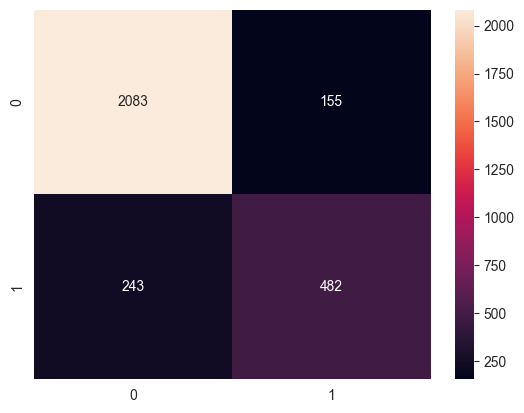

In [999]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

## Data Explanation

1. The number 1974 in the top-left corner represents the count of true negatives (TN), indicating instances where the true class is negative, and the model correctly predicted them as negative.
2. The number 114 in the top-right corner represents the count of false positives (FP), indicating instances where the true class is negative, but the model incorrectly predicted them as positive.
3. The number 220 in the bottom-left corner represents the count of false negatives (FN), indicating instances where the true class is positive, but the model incorrectly predicted them as negative.
4. The number 428 in the bottom-right corner represents the count of true positives (TP), indicating instances where the true class is positive, and the model correctly predicted them as positive.

## Data predicting in the final testing dataset

Now we finally reach the predicting part. We now use our trained model to predict data in data/testdata.csv. We predict it and store the result in data/result.csv 

In [1000]:
# Load the final testing dataset
test_data = pd.read_csv('data/testdata.csv')
test_data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,71,Private,157909,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,2964,0,60,United-States
1,34,Private,226443,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
2,36,Private,311255,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0,0,40,Haiti
3,32,Private,229732,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States
4,20,Private,212582,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,16,United-States


In [1001]:
categorical_columns = ['age','workclass','fnlwgt', 'education','education.num' ,'marital.status', 'occupation', 'relationship', 'race', 'sex','hours.per.week', 'native.country']

# 针对每一列进行标签编码
for column in categorical_columns:
    test_data[column] = label_encoder.fit_transform(test_data[column])

test_data = scaler.transform(test_data)

# Predicting labels for the test data
predictions = xgb.predict(test_data)


#### Data Storage

In [1002]:
# Storing the predictions in a DataFrame
test_predictions = pd.DataFrame({'Prediction': predictions})

# Writing the predictions to a CSV file
test_predictions.to_csv('predict/XGBoost_predictions.csv', index=False)

# 打开一个文本文件，并将 DataFrame 中的 'predictions' 列数据写入文件
with open('predict/XGBoostPredictions.txt', 'w') as f:
    # 遍历 'predictions' 列中的每个值，并将其写入文件
    for value in test_predictions['Prediction']:
        f.write(str(value) + '\n')

print("Predictions saved successfully to 'predict/XGBoost_predictions.csv' and predict/XGBoostPredictions.txt")
test_predictions.head(10)

Predictions saved successfully to 'predict/XGBoost_predictions.csv' and predict/XGBoostPredictions.txt


,Prediction
0,0
1,1
2,0
3,1
4,0
5,0
6,0
7,1
8,0
9,1


## Comparison with XGBoost in Autogluon

After checking the predict data, we find the data is different with the one by Autogluon. This is may because Autogluon has done updating on tuning the hyperparameter better.

In [1003]:
# 统计值为 1 的数量
count_ones = (test_predictions['Prediction'] == 1).sum()

print("我们的XGBoost中预测数值为 1 的数量:", count_ones)


test_dataAuto = pd.read_csv('predict/Autogluon_predictions.csv')
# 统计值为 1 的数量
count_ones2 = (test_dataAuto['Predictions'] == 1).sum()

print("Autogluon预测数值为 1 的数量:", count_ones2)

# 统计差异的计数
diff_count = (test_predictions['Prediction'] != test_dataAuto['Predictions']).sum()
print("两个数据集 'predictions' 列的差异:", diff_count)

我们的XGBoost中预测数值为 1 的数量: 1929
Autogluon预测数值为 1 的数量: 1990
两个数据集 'predictions' 列的差异: 451


同样的代码，跑出来的数据可能是不一样的（神奇）
我在scikit-learn 1.5.0 里跑XGBoost是1930个数据，在 1.4.0版本里只能跑出1929个数据
Autogluon在 1.1.0 版本上跑出来是1990个1，在anaconda的版本里跑出来是1980个1
所以数据解释有差异比较正常（可能是包更新的原因）